In [2]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
root = ''

model = 'WideDeep__KuaiRand.pt'

immers_df = pd.read_csv(root+model.split('.pt')[0]+'_only_test_all.csv',sep='\t') 

immers_df.head(5)

,user_id,item_id,time,predictions
0,0,1329429,1649467982289,-0.034268
1,0,346081,1649467982289,0.038539
2,0,2058916,1649467982289,0.175721
3,0,2528540,1649467982289,-0.253172
4,0,1966868,1649467982289,-0.259092


In [ ]:
has_nan = immers_df['predictions'].isnull().any()
print("Contains NaN:", has_nan)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

immers_df_nor = immers_df.copy()
immers_df_nor['predictions'] = scaler.fit_transform(immers_df[['predictions']])

## immersion v.s. time diff

In [15]:
timediff_dict_path = 'timediff_dict.json'

with open(timediff_dict_path,'r') as f:
    timediff_dict = json.load(f)
    
data_list = []
for user_id, items in timediff_dict.items():
    for item_id, times in items.items():
        for time, recency in times.items():
            data_list.append((user_id, item_id, time, recency))
            
print(data_list[:5])

[('0', '1724077', '1649467982289', 0.0), ('0', '1252602', '1649467982289', 0.0), ('0', '3872621', '1649467982289', 0.0), ('0', '2378158', '1649467982289', 0.0), ('0', '2291992', '1649467982289', 0.0)]


In [16]:
timediff_df = pd.DataFrame(data_list, columns=['user_id', 'item_id', 'time', 'timediff'])
print(timediff_df.head(5))

column_types = immers_df_nor.dtypes
print(column_types)
column_types = timediff_df.dtypes
print(column_types)

timediff_df['user_id'] = timediff_df['user_id'].astype(int)
timediff_df['item_id'] = timediff_df['item_id'].astype(int)
timediff_df['time'] = timediff_df['time'].astype(int)


timediff_immers_df = pd.merge(immers_df_nor, timediff_df, on=['user_id', 'item_id', 'time'], how='left')
print(timediff_immers_df.head(5))
print(len(timediff_immers_df))
timediff_immers_df = timediff_immers_df[timediff_immers_df['timediff']!=-1]
print(len(timediff_immers_df))

def format_timedelta(td):
    days = td.days
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{days}天{hours}小时{minutes}分钟{seconds}秒"


timediff_immers_df['formatted_timediff'] = pd.to_timedelta(timediff_immers_df['timediff'], unit='ms')
timediff_immers_df['formatted_timediff'] = timediff_immers_df['formatted_timediff'].apply(format_timedelta)
timediff_immers_df.head(5)

# 现

  user_id  item_id           time  timediff
0       0  1724077  1649467982289       0.0
1       0  1252602  1649467982289       0.0
2       0  3872621  1649467982289       0.0
3       0  2378158  1649467982289       0.0
4       0  2291992  1649467982289       0.0
user_id          int64
item_id          int64
time             int64
predictions    float64
dtype: object
user_id      object
item_id      object
time         object
timediff    float64
dtype: object
   user_id  item_id           time  predictions   timediff
0        0  1329429  1649467982289     0.494289        0.0
1        0   346081  1649467982289     0.506423        0.0
2        0  2058916  1649467982289     0.529287        0.0
3        0  2528540  1649467982289     0.457805        0.0
4        0  1966868  1649467982289     0.456818  7150363.0
4155344
4154361


,user_id,item_id,time,predictions,timediff,formatted_timediff
0,0,1329429,1649467982289,0.494289,0.0,0天0小时0分钟0秒
1,0,346081,1649467982289,0.506423,0.0,0天0小时0分钟0秒
2,0,2058916,1649467982289,0.529287,0.0,0天0小时0分钟0秒
3,0,2528540,1649467982289,0.457805,0.0,0天0小时0分钟0秒
4,0,1966868,1649467982289,0.456818,7150363.0,0天1小时59分钟10秒


In [17]:
def extract_days(formatted_str):
    # 分割字符串以获取“天”数
    days = formatted_str.split('天')[0]
    return int(days)

# 应用函数并创建新的列
timediff_immers_df['days'] = timediff_immers_df['formatted_timediff'].apply(extract_days)
timediff_immers_df.head(5)


def extract_hours(formatted_str):
    # 分割字符串以获取“天”数
    hours = formatted_str.split('天')[1].split('小时')[0]
    return int(hours)

# 应用函数并创建新的列
timediff_immers_df['hours'] = timediff_immers_df['formatted_timediff'].apply(extract_hours)
timediff_immers_df.head(5)

,user_id,item_id,time,predictions,timediff,formatted_timediff,days,hours
0,0,1329429,1649467982289,0.494289,0.0,0天0小时0分钟0秒,0,0
1,0,346081,1649467982289,0.506423,0.0,0天0小时0分钟0秒,0,0
2,0,2058916,1649467982289,0.529287,0.0,0天0小时0分钟0秒,0,0
3,0,2528540,1649467982289,0.457805,0.0,0天0小时0分钟0秒,0,0
4,0,1966868,1649467982289,0.456818,7150363.0,0天1小时59分钟10秒,0,1


In [18]:
timediff_counts = timediff_immers_df['days'].value_counts()
print(timediff_counts)
def correlation(df):
    pearson_corr = df['days'].corr(df['predictions'])
    print("days v.s. immersion: pearson corr", pearson_corr)

    # 计算斯皮尔曼相关系数
    spearman_corr = df['days'].corr(df['predictions'], method='spearman')
    print("days v.s. immersion: spearman corr", spearman_corr)

    # 计算肯德尔相关系数
    kendall_corr = df['days'].corr(df['predictions'], method='kendall')
    print("days v.s. immersion: kendall corr", kendall_corr)

    pearson_corr = df['timediff'].corr(df['predictions'])
    print("timedff v.s. immersion: pearson corr", pearson_corr)

    # 计算斯皮尔曼相关系数
    spearman_corr = df['timediff'].corr(df['predictions'], method='spearman')
    print("timedff v.s. immersion: spearman corr", spearman_corr)

    # 计算肯德尔相关系数
    kendall_corr = df['timediff'].corr(df['predictions'], method='kendall')
    print("timedff v.s. immersion: kendall corr", kendall_corr)
correlation(timediff_immers_df)

0     4140324
1        5956
2        2775
3        1673
4        1122
5         806
6         613
7         383
8         250
9         174
10        129
11         90
12         54
13         12
Name: days, dtype: int64
days v.s. immersion: pearson corr -0.03210587927984605
days v.s. immersion: spearman corr -0.043839483825242886
days v.s. immersion: kendall corr -0.035770036919496366
timedff v.s. immersion: pearson corr -0.03750350034726554
timedff v.s. immersion: spearman corr 0.1504288163162451
timedff v.s. immersion: kendall corr 0.11714933342402942


8081
4140324
5956


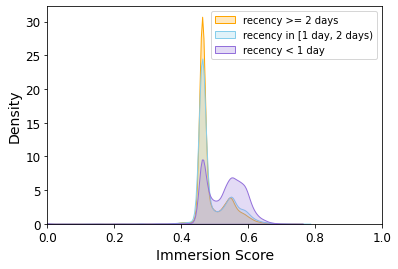

In [19]:
diff_day_more1_predictions = timediff_immers_df[timediff_immers_df['days']>=2]['predictions'].values
print(len(diff_day_more1_predictions))
diff_day_equal0_predictions = timediff_immers_df[timediff_immers_df['days']==0]['predictions'].values
print(len(diff_day_equal0_predictions))
diff_day_equal1_predictions = timediff_immers_df[timediff_immers_df['days']==1]['predictions'].values
print(len(diff_day_equal1_predictions))

sampled_diff_day_equal0_predictions = np.random.choice(diff_day_equal0_predictions, size=10000, replace=False)

sns.kdeplot(diff_day_more1_predictions, color='orange', fill=True, label='recency >= 2 days')
sns.kdeplot(diff_day_equal1_predictions, color='skyblue', fill=True, label='recency in [1 day, 2 days)')
sns.kdeplot(sampled_diff_day_equal0_predictions, color='MediumPurple', fill=True, label='recency < 1 day')
plt.xlim(0,1)
plt.ylabel('Density',fontsize=14)
plt.xlabel('Immersion Score',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=10)
plt.show()

8081
5956
10671
4129653


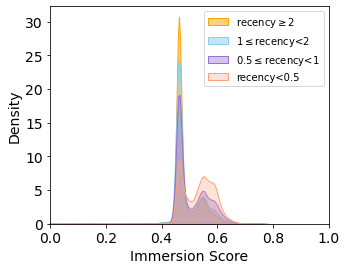

In [20]:
diff_day_more1_predictions = timediff_immers_df[timediff_immers_df['days']>=2]['predictions'].values
print(len(diff_day_more1_predictions))
# diff_day_equal2_predictions = timediff_immers_df[timediff_immers_df['days']==2]['predictions'].values
# print(len(diff_day_equal2_predictions))
diff_day_equal1_predictions = timediff_immers_df[timediff_immers_df['days']==1]['predictions'].values
print(len(diff_day_equal1_predictions))
diff_day_equal0_hours_more12_predictions = timediff_immers_df[(timediff_immers_df['days'] == 0) & (timediff_immers_df['hours'] >= 12)]['predictions'].values
print(len(diff_day_equal0_hours_more12_predictions))
diff_day_equal0_hours_less12_predictions = timediff_immers_df[(timediff_immers_df['days'] == 0) & (timediff_immers_df['hours'] < 12)]['predictions'].values
print(len(diff_day_equal0_hours_less12_predictions))

diff_day_equal0_hours_less12_predictions = np.random.choice(diff_day_equal0_hours_less12_predictions, size=10000, replace=False)
diff_day_equal0_hours_more12_predictions = np.random.choice(diff_day_equal0_hours_more12_predictions, size=10000, replace=False)

plt.figure(figsize=(5,4))

sns.kdeplot(diff_day_more1_predictions, color='orange', fill=True, label='recency$\geq$2', alpha=0.5)
sns.kdeplot(diff_day_equal1_predictions, color='skyblue', fill=True, label='1$\leq$recency<2', alpha=0.5)
sns.kdeplot(diff_day_equal0_hours_more12_predictions, color='MediumPurple', fill=True, label='0.5$\leq$recency<1', alpha=0.4)

sns.kdeplot(diff_day_equal0_hours_less12_predictions, color='lightsalmon', fill=True, label='recency<0.5', alpha=0.3)

plt.xlim(0,1)
plt.ylabel('Density',fontsize=14)
plt.xlabel('Immersion Score',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=10)
plt.savefig('Recency_WideDeep.pdf')
plt.show()

8081
5956
10671
4129653



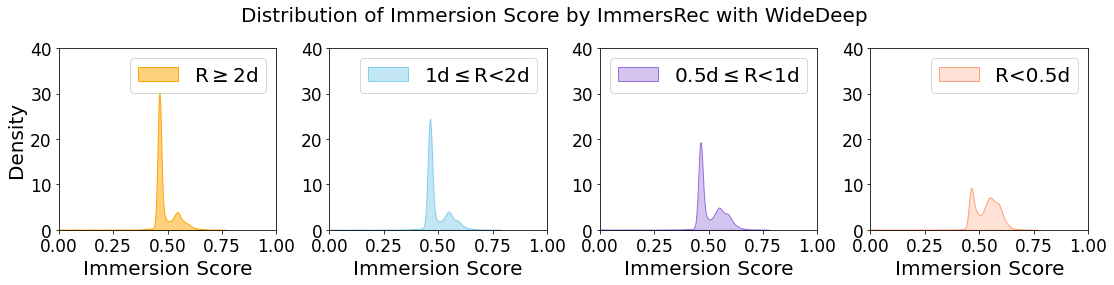

Proportion of diff_day_more1_predictions < 0.5: 0.73
Proportion of diff_day_equal1_predictions < 0.5: 0.69
Proportion of diff_day_equal0_hours_more12_predictions < 0.5: 0.57
Proportion of diff_day_equal0_hours_less12_predictions < 0.5: 0.34


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

diff_day_more1_predictions = timediff_immers_df[timediff_immers_df['days']>=2]['predictions'].values
print(len(diff_day_more1_predictions))
# diff_day_equal2_predictions = timediff_immers_df[timediff_immers_df['days']==2]['predictions'].values
# print(len(diff_day_equal2_predictions))
diff_day_equal1_predictions = timediff_immers_df[timediff_immers_df['days']==1]['predictions'].values
print(len(diff_day_equal1_predictions))
diff_day_equal0_hours_more12_predictions = timediff_immers_df[(timediff_immers_df['days'] == 0) & (timediff_immers_df['hours'] >= 12)]['predictions'].values
print(len(diff_day_equal0_hours_more12_predictions))
diff_day_equal0_hours_less12_predictions = timediff_immers_df[(timediff_immers_df['days'] == 0) & (timediff_immers_df['hours'] < 12)]['predictions'].values
print(len(diff_day_equal0_hours_less12_predictions))

print()

diff_day_equal0_hours_less12_predictions = np.random.choice(diff_day_equal0_hours_less12_predictions, size=10000, replace=False)
diff_day_equal0_hours_more12_predictions = np.random.choice(diff_day_equal0_hours_more12_predictions, size=10000, replace=False)

fig, axes = plt.subplots(1, 4, figsize=(15.5, 4))

fig.suptitle('Distribution of Immersion Score by ImmersRec with WideDeep', fontsize=20)

sns.kdeplot(diff_day_more1_predictions, color='orange', fill=True, label='R$\geq$2d', alpha=0.5, ax=axes[0])
axes[0].set_xlim(0, 1)
axes[0].set_ylabel('Density', fontsize=20)
axes[0].set_ylim(0,40)
axes[0].set_xlabel('Immersion Score', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=17)
axes[0].legend(fontsize=20)

sns.kdeplot(diff_day_equal1_predictions, color='skyblue', fill=True, label='1d$\leq$R<2d', alpha=0.5, ax=axes[1])
axes[1].set_xlim(0, 1)
# axes[1].set_ylabel('Density', fontsize=20)
axes[1].set_ylabel('')
axes[1].set_ylim(0,40)
axes[1].set_xlabel('Immersion Score', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=17)
axes[1].legend(fontsize=20)

sns.kdeplot(diff_day_equal0_hours_more12_predictions, color='MediumPurple', fill=True, label='0.5d$\leq$R<1d', alpha=0.4, ax=axes[2])
axes[2].set_xlim(0, 1)
# axes[2].set_ylabel('Density', fontsize=20)
axes[2].set_ylabel('')
axes[2].set_ylim(0,40)
axes[2].set_xlabel('Immersion Score', fontsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=17)
axes[2].legend(fontsize=20)

sns.kdeplot(diff_day_equal0_hours_less12_predictions, color='lightsalmon', fill=True, label='R<0.5d', alpha=0.3, ax=axes[3])
axes[3].set_xlim(0, 1)
# axes[3].set_ylabel('Density', fontsize=20)
axes[3].set_ylabel('')
axes[3].set_ylim(0,40)
axes[3].set_xlabel('Immersion Score', fontsize=20)
axes[3].tick_params(axis='both', which='major', labelsize=17)
axes[3].legend(fontsize=20)

plt.tight_layout()
plt.savefig('Recency_WideDeep.pdf')
plt.show()

proportion_less_0_5_more1 = np.sum(diff_day_more1_predictions < 0.5) / len(diff_day_more1_predictions)
proportion_less_0_5_equal1 = np.sum(diff_day_equal1_predictions < 0.5) / len(diff_day_equal1_predictions)
proportion_less_0_5_more12_hours = np.sum(diff_day_equal0_hours_more12_predictions < 0.5) / len(diff_day_equal0_hours_more12_predictions)
proportion_less_0_5_less12_hours = np.sum(diff_day_equal0_hours_less12_predictions < 0.5) / len(diff_day_equal0_hours_less12_predictions)
print(f'Proportion of diff_day_more1_predictions < 0.5: {proportion_less_0_5_more1:.2f}')
print(f'Proportion of diff_day_equal1_predictions < 0.5: {proportion_less_0_5_equal1:.2f}')
print(f'Proportion of diff_day_equal0_hours_more12_predictions < 0.5: {proportion_less_0_5_more12_hours:.2f}')
print(f'Proportion of diff_day_equal0_hours_less12_predictions < 0.5: {proportion_less_0_5_less12_hours:.2f}')